# Mega Case Study: Hybrid Deep Learning Model

## The Goal
We will combine **Unsupervised Learning (SOM)** with **Supervised Learning (ANN)** to create a powerful Fraud Detection System.

## The Workflow
1.  **Stage 1 (Discovery)**: Use SOM to identify clusters of customers. The SOM will naturally group "Normal" behaviors and separate "Outliers".
2.  **Stage 2 (Labeling)**: We assume the SOM is correct. We label all customers in the outlier neurons as "High Risk" (1) and everyone else as "Safe" (0).
3.  **Stage 3 (Prediction)**: We train an Artificial Neural Network (ANN) on these new labels. This gives us a model that can predict the *Probability of Fraud* for any new customer in milliseconds, without needing to retrain the map.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Part 1: The SOM (Data Preparation & Training)
We repeat the data pipeline from the Credit Card case study.

In [2]:
# 1. Download and Clean Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data"
dataset = pd.read_csv(url, header=None)

# Handle Missing Values
dataset = dataset.replace('?', np.nan)
for col in dataset.columns:
    dataset[col] = pd.to_numeric(dataset[col], errors='ignore')
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].fillna(dataset[col].mode()[0])
    else:
        dataset[col] = dataset[col].fillna(dataset[col].mean())

# Encode Categorical
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = le.fit_transform(dataset[col])

# Extract Features
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Scale to 0-1
sc = MinMaxScaler(feature_range=(0, 1))
X_scaled = sc.fit_transform(X)

print(f"Data Ready: {X_scaled.shape}")

Data Ready: (690, 15)


/var/folders/fv/1glf1w45215d_trl8514hbnr0000gp/T/ipykernel_52840/896845608.py:8: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset[col] = pd.to_numeric(dataset[col], errors='ignore')


In [3]:
# 2. Train SOM
# Reuse SimpleSOM Class
class SimpleSOM:
    def __init__(self, x, y, input_len):
        self.x = x
        self.y = y
        self.weights = np.random.random((x, y, input_len))
        self.learning_rate = 0.5
        self.radius = max(x, y) / 2
        self.time_constant = 1.0

    def find_winner(self, sample):
        diff = self.weights - sample
        sq_dist = np.sum(diff**2, axis=2)
        return np.unravel_index(np.argmin(sq_dist), (self.x, self.y))

    def update_weights(self, sample, winner, iteration):
        rad = self.radius * np.exp(-iteration / self.time_constant)
        lr = self.learning_rate * np.exp(-iteration / self.time_constant)
        if rad < 1e-10: rad = 1e-10
        for i in range(self.x):
            for j in range(self.y):
                dist = np.sqrt((i - winner[0])**2 + (j - winner[1])**2)
                if dist <= rad:
                    influence = np.exp(-(dist**2) / (2 * (rad**2)))
                    self.weights[i, j] += lr * influence * (sample - self.weights[i, j])

    def train(self, data, num_epochs):
        total_steps = len(data) * num_epochs
        self.time_constant = total_steps / np.log(self.radius)
        step = 0
        for epoch in range(num_epochs):
            np.random.shuffle(data)
            for sample in data:
                winner = self.find_winner(sample)
                self.update_weights(sample, winner, step)
                step += 1

    def distance_map(self):
        dmap = np.zeros((self.x, self.y))
        for i in range(self.x):
            for j in range(self.y):
                neighbors = []
                if i > 0: neighbors.append(self.weights[i-1, j])
                if i < self.x-1: neighbors.append(self.weights[i+1, j])
                if j > 0: neighbors.append(self.weights[i, j-1])
                if j < self.y-1: neighbors.append(self.weights[i, j+1])
                if len(neighbors) > 0:
                    dists = [np.linalg.norm(self.weights[i, j] - n) for n in neighbors]
                    dmap[i, j] = np.mean(dists)
        return (dmap - dmap.min()) / (dmap.max() - dmap.min())

som = SimpleSOM(10, 10, X_scaled.shape[1])
som.train(X_scaled, num_epochs=100)
print("SOM Trained")

SOM Trained


# The Great Comparison
Now we will plot two maps side-by-side to understand the difference between **Labels** and **Outliers**.

## Visualization 1: Ground Truth (What the Bank Did)
This map uses the original `y` labels from the dataset.
-   **Green Square**: The Bank APPROVED this customer.
-   **Red Circle**: The Bank REJECTED this customer.

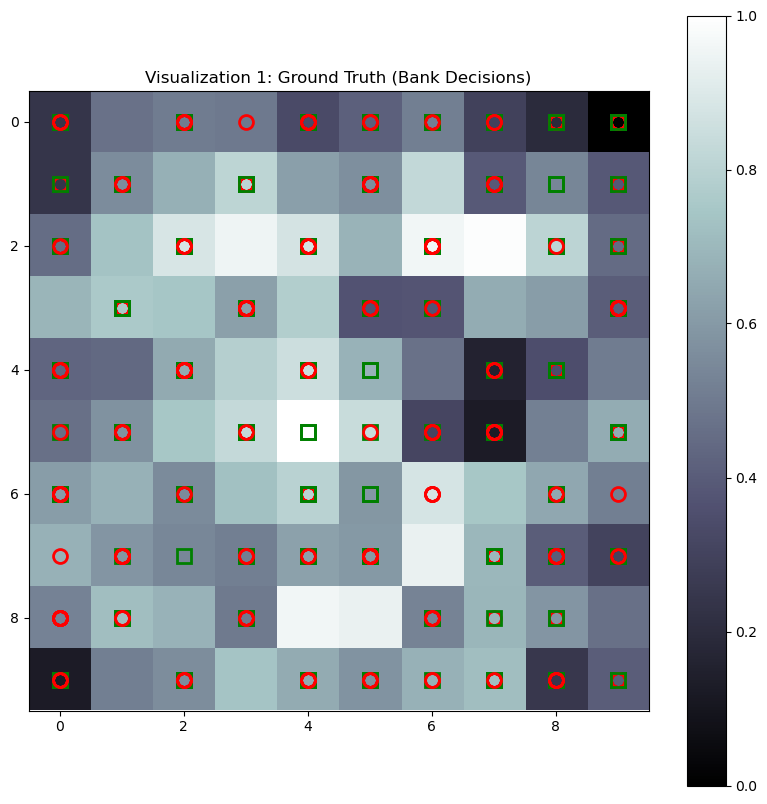

In [4]:
dmap = som.distance_map()

plt.figure(figsize=(10, 10))
plt.imshow(dmap, cmap='bone', interpolation='none')
plt.colorbar()

markers = ['s', 'o']
colors = ['g', 'r']

for i, x in enumerate(X_scaled):
    w = som.find_winner(x)
    # y[i] is the actual label (0=Approved, 1=Rejected)
    plt.plot(w[1], w[0],
             markers[y[i]],
             markeredgecolor=colors[y[i]],
             markerfacecolor='None',
             markersize=10,
             markeredgewidth=2)

plt.title('Visualization 1: Ground Truth (Bank Decisions)')
plt.show()

## Visualization 2: Hybrid Outliers (What the SOM Thinks)
This map ignores the bank's decision. It only cares about the **Topology**.
-   **Green Square**: The Customer fits into a "Safe Cluster" (Low mean distance).
-   **Red Circle**: The Customer is an "Outlier" (High mean distance) -> **Potential Fraud!**

**Look for Discrepancies**: Find a customer who was **Approved (Green Square)** in Vis 1, but is an **Outlier (Red Circle)** in Vis 2. THAT is the money shot.

/var/folders/fv/1glf1w45215d_trl8514hbnr0000gp/T/ipykernel_52840/3542714500.py:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  markers[is_outlier],
/var/folders/fv/1glf1w45215d_trl8514hbnr0000gp/T/ipykernel_52840/3542714500.py:19: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  markeredgecolor=colors[is_outlier],


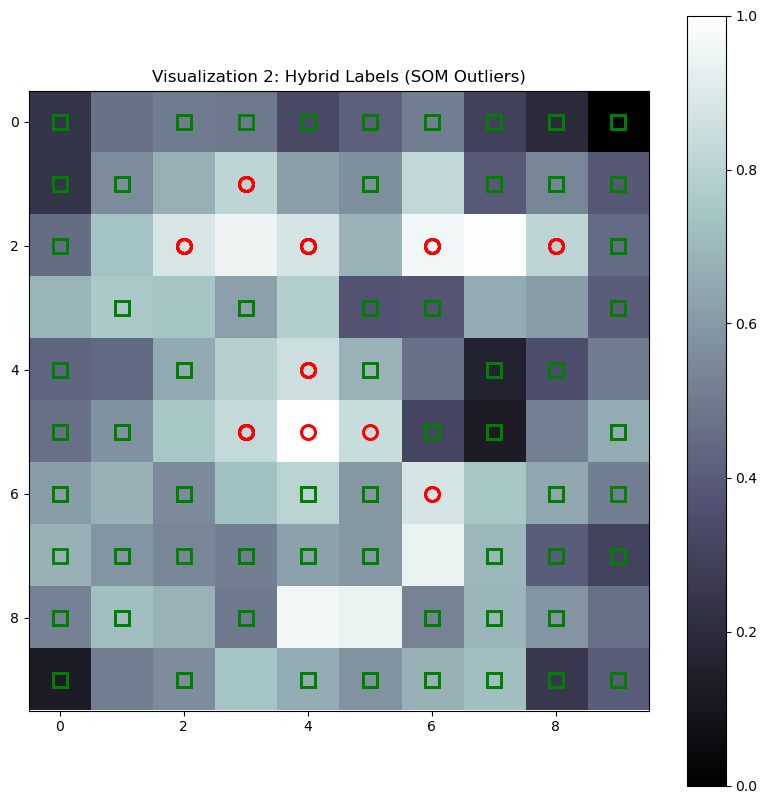

Found 16 outlier neurons out of 100.


In [5]:
# Calculate Outliers based on the Map Logic
threshold = 0.8
outlier_map = dmap > threshold

plt.figure(figsize=(10, 10))
plt.imshow(dmap, cmap='bone', interpolation='none')
plt.colorbar()

markers = ['s', 'o']
colors = ['g', 'r']

for i, x in enumerate(X_scaled):
    w = som.find_winner(x)
    # is_outlier depends on the map distance, NOT the dataset label
    is_outlier = outlier_map[w[0], w[1]]
    
    plt.plot(w[1], w[0],
             markers[is_outlier],
             markeredgecolor=colors[is_outlier],
             markerfacecolor='None',
             markersize=10,
             markeredgewidth=2)

plt.title('Visualization 2: Hybrid Labels (SOM Outliers)')
plt.show()

print(f"Found {np.sum(outlier_map)} outlier neurons out of 100.")

In [6]:
# Create the Target Vector for ANN
y_hybrid = np.zeros(len(X_scaled))

for i, x in enumerate(X_scaled):
    w = som.find_winner(x)
    # If the winning neuron is in the outlier map
    if outlier_map[w[0], w[1]]:
        y_hybrid[i] = 1  # High Risk

print(f"Total Customers: {len(y_hybrid)}")
print(f"Flagged as High Risk: {int(sum(y_hybrid))}")

Total Customers: 690
Flagged as High Risk: 87


## Part 3: Supervised Learning (The ANN)
Now we have labels! `X_scaled` is input, `y_hybrid` is output.
We use `MLPClassifier` from Scikit-Learn (a standard Multi-Layer Perceptron), which is equivalent to a Dense Neural Network.

In [7]:
from sklearn.neural_network import MLPClassifier

# Initialize Model
# hidden_layer_sizes=(16, 16) -> Two hidden layers with 16 neurons each
# activation='relu' -> Rectified Linear Unit
# max_iter=200 -> Number of epochs
ann = MLPClassifier(hidden_layer_sizes=(16, 16), 
                    activation='relu', 
                    solver='adam', 
                    max_iter=200, 
                    random_state=42)

# Train
ann.fit(X_scaled, y_hybrid)

print("ANN Trained successfully.")

ANN Trained successfully.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Part 4: Predicting Fraud Probability
Now we can predict the probability for any customer.

In [8]:
# Get probabilities for the whole dataset
# predict_proba returns [prob_0, prob_1]. We want prob_1 (Column 1)
y_pred = ann.predict_proba(X_scaled)[:, 1]

# Let's concatenate Customer ID (Index) with their Fraud Probability
# We will sort by Probability descending to find the "Most Wanted"
# Reshape y_pred to be a column
y_pred = y_pred.reshape(-1, 1)

results = np.concatenate((dataset.iloc[:, 0:1].values, y_pred), axis=1)

# Sort by predicted probability (Column 1)
results_sorted = results[results[:, 1].argsort()[::-1]]

print("Top 10 High Risk Customers (ID vs Probability):")
for i in range(10):
    print(f"Customer ID {results_sorted[i][0]:.0f}: {results_sorted[i][1]*100:.2f}% Risk")

Top 10 High Risk Customers (ID vs Probability):
Customer ID 0: 99.26% Risk
Customer ID 1: 99.12% Risk
Customer ID 1: 98.92% Risk
Customer ID 0: 97.85% Risk
Customer ID 1: 97.80% Risk
Customer ID 1: 97.78% Risk
Customer ID 0: 97.62% Risk
Customer ID 0: 97.50% Risk
Customer ID 1: 97.04% Risk
Customer ID 1: 96.14% Risk
